a_r = 3.0
b_r = 1.2
Epoch 0 | D Loss: 1.4005 | G Loss: 0.5556
Epoch 200 | D Loss: 1.3666 | G Loss: 0.6787
Epoch 400 | D Loss: 1.3526 | G Loss: 0.6956
Epoch 600 | D Loss: 1.2664 | G Loss: 0.7586
Epoch 800 | D Loss: 1.2980 | G Loss: 0.8408
Epoch 1000 | D Loss: 1.3591 | G Loss: 0.7488
Epoch 1200 | D Loss: 1.5488 | G Loss: 0.7405
Epoch 1400 | D Loss: 1.5756 | G Loss: 0.5951
Epoch 1600 | D Loss: 1.3513 | G Loss: 0.7255
Epoch 1800 | D Loss: 1.3117 | G Loss: 0.8282


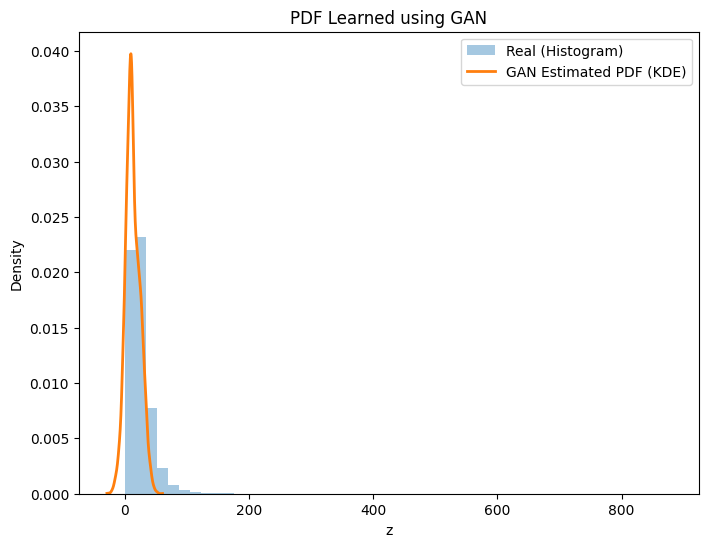

In [5]:
# ============================================================
# Learning PDF using GAN (NO2 Dataset)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

# ==============================
# Step 0: Load Dataset
# ==============================

data = pd.read_csv("data.csv", encoding="latin1")

# Select NO2 column (adjust column name if required)
x = data["no2"].dropna().values.reshape(-1, 1)

# ==============================
# Step 1: Transformation
# ==============================

r = 102317053

a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print("a_r =", a_r)
print("b_r =", b_r)

# Transformation
z = x + a_r * np.sin(b_r * x)

# Normalize for stable GAN training
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)

z_tensor = torch.FloatTensor(z_scaled)

# ==============================
# Step 2: GAN Architecture
# ==============================

latent_dim = 5
hidden_dim = 32

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0005)
optimizer_D = optim.Adam(D.parameters(), lr=0.0005)

# ==============================
# Step 2: Training GAN
# ==============================

epochs = 2000
batch_size = 64

for epoch in range(epochs):

    # ---------------------
    # Train Discriminator
    # ---------------------

    idx = np.random.randint(0, z_tensor.size(0), batch_size)
    real_samples = z_tensor[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    noise = torch.randn(batch_size, latent_dim)
    fake_samples = G(noise)

    D_real = D(real_samples)
    D_fake = D(fake_samples.detach())

    loss_real = criterion(D_real, real_labels)
    loss_fake = criterion(D_fake, fake_labels)
    loss_D = loss_real + loss_fake

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    # ---------------------
    # Train Generator
    # ---------------------

    noise = torch.randn(batch_size, latent_dim)
    fake_samples = G(noise)

    D_fake = D(fake_samples)
    loss_G = criterion(D_fake, real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

# ==============================
# Step 3: PDF Approximation
# ==============================

# Generate large number of samples
num_samples = 10000
noise = torch.randn(num_samples, latent_dim)
generated = G(noise).detach().numpy()

# Inverse scaling
generated = scaler.inverse_transform(generated)

# KDE Estimation
kde = gaussian_kde(generated.flatten())

z_range = np.linspace(generated.min(), generated.max(), 500)
pdf_estimated = kde(z_range.reshape(1, -1))

# ==============================
# Plot Results
# ==============================

plt.figure(figsize=(8,6))

# Real histogram
plt.hist(z, bins=50, density=True, alpha=0.4, label="Real (Histogram)")

# GAN KDE PDF
plt.plot(z_range, pdf_estimated, label="GAN Estimated PDF (KDE)", linewidth=2)

plt.title("PDF Learned using GAN")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.show()
